# Using the DNMT3A model and knocking in/out genes 
####  This runs the simulation for the DNMT3A model for all 8 profiles mentioned in Figure 6 within the Palma paper (made to be as similar to the r code dnmt3a_sim.R)

## Importing codes and preparing inputs for network and simulation

### Importing BMatrix and BooleanNetwork code

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# import booleanNetwork module from ./src
import sys
sys.path.append('C:/Users/15167/OneDrive/Documents/ISB/AML-DT-BNM/jupyter_notebook/Python/BooleanNetwork/')
import booleanNetwork as bn
import BMatrix  

### Importing the patient data (using s5 for clinical data and using s7 for patient mutation profiles)

In [2]:
# s7_data_combined has all the patient's mutation profiles
s5_df = pd.read_excel("C:/Users/15167/OneDrive/Documents/ISB/AML-DT-BNM/raw_data/s5_table.xlsx")

s7_df = pd.read_excel("C:/Users/15167/OneDrive/Documents/ISB/AML-DT-BNM/raw_data/python_s7.xlsx")
mutation_profiles = s7_df['mutation_profiles'].values.reshape(-1, 1)
#print(mutation_profiles)

### Getting the variables needed for the simulation (like varF and F)

In [3]:
file = 'C:/Users/15167/OneDrive/Documents/ISB/dnmt3a_equations.txt' #does not have the equations at the end

equations = BMatrix.getting_equations(file)
gene_dict = BMatrix.gene_dictionary(equations)
only_genes = BMatrix.getting_only_genes(equations)

varF = BMatrix.connectivity_matrix(equations,only_genes,gene_dict)
varF = np.array(varF)
#print(varF)

F = BMatrix.extracting_truth_table(equations,only_genes)
F = np.array(F)
#print(F)

ngenes= len(equations)

### Preparing the variables needed for calculating the scores (after simulation)

In [4]:
file_equations = 'C:/Users/15167/OneDrive/Documents/ISB/calculating_equations.txt'

equations = BMatrix.getting_equations(file_equations)
cal_functions = BMatrix.calculating_functions(equations)
cal_only_genes = BMatrix.calculating_only_genes(equations)

### Cleaning up the s5 and s7 data and combining it into one merged_df
#### Going to use the profiles I get from merged_df as the ones I use for the simulation

In [5]:
#merging together the s7_df and s5_df
common = np.intersect1d(s5_df['labId'], s7_df['labId']) #getting the common labId labels 
s5_merged_df = s5_df[s5_df['labId'].isin(common)] 
s7_merged_df = s7_df[s7_df['labId'].isin(common)]

s7_merged_df = (s7_merged_df.assign(mutation_profiles=s7_merged_df['mutation_profiles'].str.split(','))
                               .explode('mutation_profiles')  #splitting the mutation_profile column
                               .query('mutation_profiles in ["DNMT3A", "FLT3", "NPM1"]') #making anything that isn't DNMT3A, NPM1, FLT3 into NA
                               .groupby('labId')['mutation_profiles'] #group mutation_profiles column by labId
                               .apply(lambda x: ','.join(x)) #recombine so the NAs fall out of mutation_profiles
                               .str.split(',') #split the mutation_profile columns again 
                               .apply(set) #get unique values only
                               .str.join(',') #recombine
                               .reset_index(name='mutation_profiles')) 

#now with the fixed s7_merged_df and the s5_merged_df, make a large merged_df with both mutation_profiles and BM and PB data
merged_df = pd.merge(s7_merged_df, s5_merged_df, on='labId', how='outer')

merged_df['mutation_profiles'].fillna('', inplace=True)

#renaming the PB and BM columns 
merged_df = merged_df.rename(columns={"%.Blasts.in.BM": "BM_Blast", 
                                      "%.Blasts.in.PB": "PB_Blast"})

#making sure PB and BM are numeric
merged_df['BM_Blast'] = pd.to_numeric(merged_df['BM_Blast'], errors='coerce')
merged_df['PB_Blast'] = pd.to_numeric(merged_df['PB_Blast'], errors='coerce')

#replacing all the NAs in PB and BM columns
merged_df['PB_Blast'] = merged_df['PB_Blast'].fillna(merged_df['PB_Blast'].mean())
merged_df['BM_Blast'] = merged_df['BM_Blast'].fillna(merged_df['BM_Blast'].mean())

## Running the simulation for all the 8 profiles from merged_df and getting the final scores

In [6]:
all_profiles = np.array([[profile] for profile in merged_df['mutation_profiles'].unique()])

In [7]:
noise_level = 0.05  # noise

mutations = {'FLT3': 1,
             'NPM1': 0,
             'DNMT3A': 0}

final_scores = {}
networks = {}

for i in range(len(all_profiles)):     
    
    mutation_varF = varF.copy()  # Create a copy of varF for each iteration    
    profile = all_profiles[i,0] # Gets the profile as a string ex. 'FLT3'
    mutation_profile = list(set(profile.split(','))) #removes any repeat values 
    
    print(mutation_profile)             

    x0 = np.random.randint(2, size=ngenes)  # random initial state resets with every profile
        
    # make the mutation_varF rows in mutation_profile all -1 
    for gene in mutation_profile:
        if len(gene) == 0:
            print('no_mutation')
        else:
            mutation_varF[[gene_dict[gene]], :] = -1  # knock the varF to -1
            x0[gene_dict[gene]] = mutations[gene]  # setting that gene's value to mutation value
                            
    #making the networks and running the simulation
    network = bn.BooleanNetwork(ngenes, mutation_varF, F, x0)
    y = network.update_noise(noise_level, 200000)
    
    #calculating the scores  
    y_range = y[-100000:]
    scores_dict = BMatrix.calculating_scores(y, cal_functions, cal_only_genes, gene_dict, y_range) #gets the scores
    
    print('finished calculating scores')
    
    final_score = np.mean(scores_dict['Network'])
    
    print(final_score)
    
    final_scores.update({profile: final_score})
    
print(final_scores)

['NPM1']
finished calculating scores
0.96273
['DNMT3A', 'FLT3']
finished calculating scores
1.39742
['FLT3']
finished calculating scores
1.34781
['NPM1', 'FLT3']
finished calculating scores
0.98711
['DNMT3A', 'NPM1']
finished calculating scores
0.9668
['DNMT3A', 'NPM1', 'FLT3']
finished calculating scores
0.98905
['DNMT3A']
finished calculating scores
1.34651
['']
no_mutation
finished calculating scores
1.15319
{'NPM1': 0.96273, 'DNMT3A,FLT3': 1.39742, 'FLT3': 1.34781, 'NPM1,FLT3': 0.98711, 'DNMT3A,NPM1': 0.9668, 'NPM1,DNMT3A,FLT3': 0.98905, 'DNMT3A': 1.34651, '': 1.15319}


## Creating the PB and BM dataframes for the scatterplots

#### Grouping the patients with the same profiles together and getting their average scores

In [8]:
PB_Blast = []
BM_Blast = []
Network_Scores = []

for i in range(len(all_profiles)):
    mutation_group = all_profiles[i,0] # Gets the profile as a string ex. 'FLT3'

    group_df = merged_df[merged_df['mutation_profiles'] == mutation_group]

    #network scores
    score = final_scores[mutation_group]
    Network_Scores.append(score)
    
    #PB Blast
    PB = group_df['PB_Blast'].mean()
    PB_Blast.append(PB)
    
    #BM Blast
    BM = group_df['BM_Blast'].mean()
    BM_Blast.append(BM)


#### Plotting the scatterplots

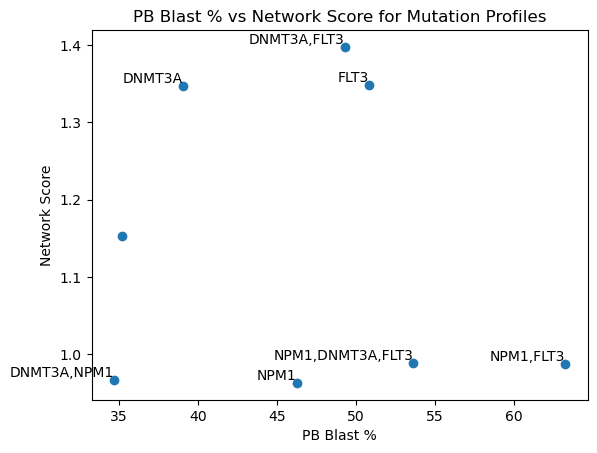

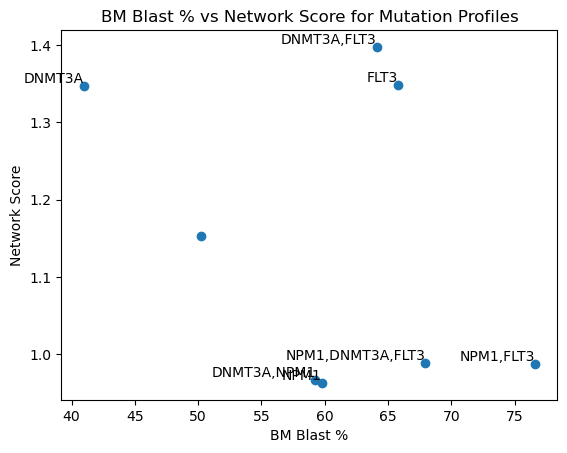

In [9]:
Mutation_Profiles = [profile for profile in merged_df['mutation_profiles'].unique()]

PB_v_Network = pd.DataFrame({
    'Mutation_Profiles': Mutation_Profiles,
    'PB_Blast': PB_Blast,
    'Network_Scores': Network_Scores
})

plt.scatter(PB_v_Network['PB_Blast'], PB_v_Network['Network_Scores'])

for x, y, label in zip(PB_v_Network['PB_Blast'], PB_v_Network['Network_Scores'], PB_v_Network['Mutation_Profiles']):
    plt.text(x, y, label, ha='right', va='bottom')

plt.xlabel('PB Blast %')
plt.ylabel('Network Score')
plt.title('PB Blast % vs Network Score for Mutation Profiles')
plt.show()



BM_v_Network = pd.DataFrame({
    'BM_Blast': BM_Blast,
    'Network_Scores': Network_Scores,
    'Mutation_Profiles': Mutation_Profiles  # Assuming Mutation_Profiles is a list
})

plt.scatter(BM_v_Network['BM_Blast'], BM_v_Network['Network_Scores'])

for x, y, label in zip(BM_v_Network['BM_Blast'], BM_v_Network['Network_Scores'], BM_v_Network['Mutation_Profiles']):
    plt.text(x, y, label, ha='right', va='bottom')

plt.xlabel('BM Blast %')
plt.ylabel('Network Score')
plt.title('BM Blast % vs Network Score for Mutation Profiles')
plt.show()


#### Performing the T-test

In [10]:
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

# t test 
t_PB, p_PB = ttest_ind(PB_Blast, Network_Scores, equal_var=False)
t_BM, p_BM = ttest_ind(BM_Blast, Network_Scores, equal_var=False)

print("T-test for PB vs Network:")
print("T-stat:", t_PB)
print("p-value:", p_PB)

print("\nT-test for BM vs Network:")
print("T-stat:", t_BM)
print("p-value:", p_BM)

T-test for PB vs Network:
T-stat: 12.999718300347931
p-value: 3.6864248743109155e-06

T-test for BM vs Network:
T-stat: 15.304085933031665
p-value: 1.2184269633977295e-06


#### Getting the pearson correlation

In [11]:
pearson_PB, _ = pearsonr(PB_Blast, Network_Scores)
pearson_BM, _ = pearsonr(BM_Blast, Network_Scores)

print("\nPearson correlation for PB vs Network:", pearson_PB)
print("Pearson correlation for BM vs Network:", pearson_BM)


Pearson correlation for PB vs Network: -0.12155652698170025
Pearson correlation for BM vs Network: -0.3626709803678907
